In [1]:
import sys
sys.path.append('C:/Users/Hubert/repos/radioman-little-helper')

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from radler.univariate import mann_whitney_u
from radler.univariate import plot_roc_curve
from radler.auto_ml import tune_model, test_model

In [2]:
data_iris = load_iris()
X = pd.DataFrame(data_iris['data'])
y = data_iris['target']==1

In [3]:
mann_whitney_u(X, y)

,U,p-value,AUC,FWER,FDR
0,2857.5,1.542841e-01,0.5715,False,False
1,3971.0,3.919743e-09,0.7942,True,True
2,2544.5,8.606063e-01,0.5089,False,False
3,2549.0,8.459355e-01,0.5098,False,False


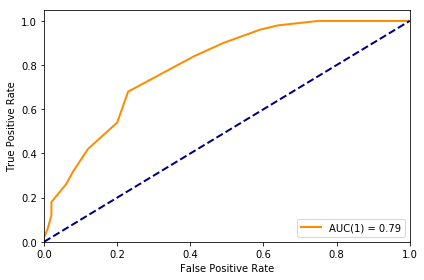

In [4]:
plot_roc_curve(X, 1, data_iris['target']==1)

In [5]:
X = pd.DataFrame(data_iris['data'])
y = data_iris['target']==1

params = dict()
# params['clf_kinds'] = ['lr1', 'lr2', 'svm', 'et', 'xgb']
params['clf_kinds'] = ['lr2', 'et']
params['fs_kinds'] = ['none']
params['sampling_kinds'] = ['none']
params['inlier_detection'] = ['none']
params['n_jobs'] = 3
params['scaler'] = 'robust'
params['rs_iters'] = 10
params['cv_kind'] = 'rskf'
params['cv_splits'] = 10
params['cv_repeats'] = 1
params['random_state'] = 313
params['df_pickle_name'] = 'test9.p'

# Test the model
auc_scores = test_model(X, y, params, n_splits=10)
print(auc_scores)
print(np.mean(auc_scores))
print(np.std(auc_scores))
file = open(params['df_pickle_name'][:-2] + '_test.txt', 'w')
file.write('AUC scores: {}\n'.format(auc_scores))
file.write('AUC mean: {}\n'.format(np.mean(auc_scores)))
file.write('AUC standard deviation: {}'.format(np.std(auc_scores)))
file.close()
# Tune the final model
tune_model(X, y, params)

Date and time: classifier - feature selection - sampling
Sun Feb  3 11:57:38 2019: lr2 - none - none
Sun Feb  3 11:57:43 2019: et - none - none
#############
Purge 1
     valid_auc  valid_std  valid_auc-std
clf                                     
lr2   0.797243   0.122047       0.675196
et    0.968930   0.043833       0.925097
Removed: lr2
Left: ['et']
Sun Feb  3 11:57:54 2019: ['et'] - ['none'] - ['none']
Test AUC: 1.0
Date and time: classifier - feature selection - sampling
Sun Feb  3 11:58:18 2019: lr2 - none - none
Sun Feb  3 11:58:21 2019: et - none - none
#############
Purge 1
     valid_auc  valid_std  valid_auc-std
clf                                     
lr2    0.78535   0.143053       0.642297
et     0.97428   0.044945       0.929335
Removed: lr2
Left: ['et']
Sun Feb  3 11:58:34 2019: ['et'] - ['none'] - ['none']
Test AUC: 1.0
Date and time: classifier - feature selection - sampling
Sun Feb  3 11:59:05 2019: lr2 - none - none
Sun Feb  3 11:59:08 2019: et - none - none
######

RandomizedSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002358D1E0048>,
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('inlier_detection', InlierDetection(method='none')), ('correlation_th', CorrelationThreshold(n_jobs=1, threshold=0.9)), ('variance_th', VarianceThreshold(threshold=0.0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampling', Sampling(adasyn=ADASYN(n_jobs=1, n_nei...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)))]),
          fit_params=None, iid='warn', n_iter=20, n_jobs=3,
          param_distributions={'inlier_detection__method': ['none'], 'correlation_th__threshold': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'sampling__kind': ['none'], 'sampling__enn__n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002358D1D5438>, 'sa..._infrastructure.rv_fro